# IMAGINE tutorial 2

## Another pipeline example and parallel computing features

Tutorial 1 briefly went through some of the basic features of IMAGINE. 
We will now perform same analysis on a different field model, this is will 
give an idea of how some fields are easier to determine than others using 
these methods.

#### ...imagine running all this in parallel...

The present tutorial also ilustrates the IMAGINE's MPI support. To be able
to do this within a Jupyter notebook, we wiil use the 
[ipyparallel](https://ipyparallel.readthedocs.io/en/latest/mpi.html) package. 
Thus, before running this notebook, you will need to start *ipython cluster* 
executing the following command on the same machine:
```
$ ipcluster start -n 4 --engines=MPIEngineSetLauncher
```

where the number of cores, set using the argumen `-n` can be changed to something 
else if needed.

#### ...imagine a different emission...

The field in this tutorial is designed to mimick emission intensities which is roughly proportional to (Galactic) magnetic field energy density, e.g. field  strength squared.

$ signal(x) = [\sin(x) \times \mathcal{G}(\mu=a_0,\sigma=b_0;seed=s)]^2 \,, \; x \in (0,2\pi)$

You will see that the influence of having variance-like fluctuations in the observable differs _dramatically_ from what we have seen in tutorial 1.

This tutorial has a threshold in data size, i.e. taking $ size<5 $ in this tutorial will fail.

<span style="color:red">**NB the following Bayesian sampling processes can be quite expensive**</span>

## Setting up parallel environment

To allow [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/mpi.html)  to work,
one must first connect to the cluster

In [1]:
import ipyparallel as ipp
cluster = ipp.Client()

Now the notebook is connected to the different ipyparellel processes running. 
The relevant packages need to be imported by all processes, this can be done 
through the *notebook magic* `%%px`, which instructs that the cell should be 
run by the ipcluster processes instead of the notebook's main kernel.

In [2]:
%%px
import numpy as np
import logging as log
import matplotlib.pyplot as plt

import imagine.observables.observable_dict as observable_dict
from imagine.likelihoods.ensemble_likelihood import EnsembleLikelihood
from imagine.fields.test_field.test_field_factory import TestFieldFactory
from imagine.priors.flat_prior import FlatPrior
from imagine.simulators.test.bi_simulator import BiSimulator
from imagine.tools.covariance_estimator import oas_cov

import corner, matplotlib
from imagine.tools.carrier_mapper import unity_mapper
from imagine.tools.mpi_helper import mpi_eye

matplotlib.use('Agg')

# Sets up parallel features
from mpi4py import MPI
comm = MPI.COMM_WORLD
mpirank = comm.Get_rank()
mpisize = comm.Get_size()

%matplotlib inline

## 1) Preparation of mock data

As in tutorial 1 (we refer the reader there for details) we first 
construct our mock data. 

In [3]:
%%px 

a0 = 3. # true value of a
b0 = 6. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 20
x = np.linspace(0,2.*np.pi,size)

np.random.seed(s)

# Constructs the signal array
signal = np.square (np.sin(x) * np.random.normal(loc=a0, scale=b0, size=size))
# The data will include random noise
data = np.vstack([signal + np.random.normal(loc=0., scale=e, size=size)])
# We assume a diagonal covariance matrix
cov = (e**2) * mpi_eye(size)

Note that [mpi_eye](https://imagine-code.readthedocs.io/en/mpi-tutorial/imagine.tools.html#imagine.tools.mpi_helper.mpi_eye) is used instead of `numpy.eye`. This produces 
the two-dimensional identity matrix which is already distributed
among different processes. This is shown in the cell below.

In [4]:
%%px
print(cov.shape)

[stdout:0] (5, 20)
[stdout:1] (5, 20)
[stdout:2] (5, 20)
[stdout:3] (5, 20)


The distributed data can then be loaded into [observable_dict](https://imagine-code.readthedocs.io/en/mpi-tutorial/imagine.observables.html#module-imagine.observables.observable_dict) objects

In [5]:
%%px
# We can add the mock data to an IMAGINE Measurements object
mock_data = observable_dict.Measurements()
mock_data.append(('test', 'nan', str(size), 'nan'), data, True)
# Likewise, can can create a IMAGINE Covariances object
mock_cov = observable_dict.Covariances() 
mock_cov.append(('test', 'nan', str(size), 'nan'), cov, True)

The property [global_data](https://imagine-code.readthedocs.io/en/mpi-tutorial/imagine.observables.html#imagine.observables.observable.Observable.global_data) gathers the distributed measurement or covariance data from all
processes and returns an array at the root process. Other processes get `None`.
The attribute [data](https://imagine-code.readthedocs.io/en/mpi-tutorial/imagine.observables.html#imagine.observables.observable.Observable) contains the *local* measurement or covariance data.

Below, we exemplify the use of these for plotting. (Note that the error bars are too small
to be visible.)

[output:0]

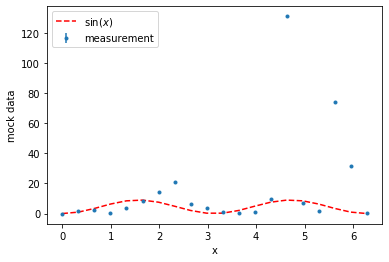

In [6]:
%%px
full_mock_data = mock_data[('test', 'nan', str(size), 'nan')].global_data
full_mock_cov = mock_cov[('test', 'nan', str(size), 'nan')].global_data

if full_mock_data is not None:
    error = np.sqrt(full_mock_cov.diagonal()) # The variance is in the diagonal 
    plt.errorbar(x, full_mock_data[0], error, linestyle='',
                 marker='.', label='measurement')
    plt.plot(x,(np.sin(x)*a0)**2,'r--', label='$\sin(x)$')
    plt.xlabel('x'); plt.ylabel('mock data'); plt.legend();

## 2) Preparation of pipeline

As in tutorial one, we need to set up a [field factory](https://imagine-code.readthedocs.io/en/mpi-tutorial/imagine.fields.test_field.html#imagine.fields.test_field.test_field_factory.TestFieldFactory), which again 
produces scalar fields of the form $f(x) = a x + \mathcal{G}(b)$

In [7]:
%%px
factory = TestFieldFactory(active_parameters=('a','b'))
# adjust parameter range for Bayesian analysis
factory.parameter_ranges = {'a':(0,10),'b':(0,10)}
factory_list = [factory]

The simulator used for this example is the [BiSimulator](https://imagine-code.readthedocs.io/en/mpi-tutorial/imagine.simulators.test.html#imagine.simulators.test.bi_simulator.BiSimulator), 
consisting of the emissivity function shown in the beginning of this notebook.



In [8]:
%%px 
simer = BiSimulator(mock_data)

The final ingredients for assembling the pipeline are a prior (flat) and setting up the
object that computes the ensemble likelyhood.


In [9]:
%%px 
prior = FlatPrior()
likelihood = EnsembleLikelihood(mock_data, mock_cov)

## 3a) Rolling out with MultiNest

Finally, we can assemble and run our pipline. 
Note parameters that control the sampling.

In [10]:
%%px 
from imagine.pipelines.multinest_pipeline import MultinestPipeline
# Assembly
ensemble_size = 100
pipeline_multinest = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
# Configuration
pipeline_multinest.random_type = 'controllable'
pipeline_multinest.seed_tracer = 23
pipeline_multinest.sampling_controllers = {'n_iter_before_update': 10,
                                           'n_live_points': 400,
                                           'verbose': True,
                                           'resume': False}
# Run
results_multinest = pipeline_multinest()

[stdout:0]   analysing data from chains/imagine_.txt
[stdout:1]   analysing data from chains/imagine_.txt
[stdout:2]   analysing data from chains/imagine_.txt
[stdout:3]   analysing data from chains/imagine_.txt


At last, after all this waiting, we can visualize the results:

[output:0]

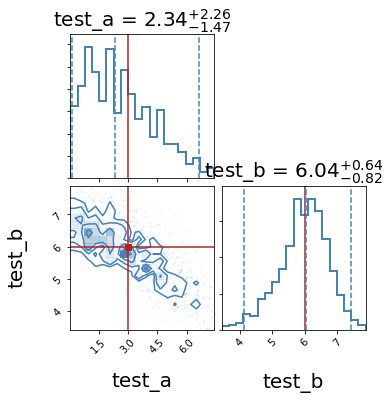

In [11]:
%%px
if mpirank == 0:
    samples = results_multinest['samples']
    # convert variables into parameters
    params = pipeline_multinest.active_parameters
    for i, param in enumerate(params): 
        low, high = pipeline_multinest.active_ranges[param]
        for j, sample in enumerate(samples[:,i]):
            samples[j, i] = unity_mapper(samples[j, i], low, high)
    
    # corner plot
    corner.corner(samples[:, :len(params)],
                          range=[0.99]*len(params),
                          quantiles=[0.02, 0.5, 0.98],
                          labels=params,
                          show_titles=True,
                          title_kwargs={"fontsize": 20},
                          color='steelblue',
                          truths=[a0,b0],
                          truth_color='firebrick',
                          plot_contours=True,
                          hist_kwargs={'linewidth': 2},
                          label_kwargs={'fontsize': 20})


## 3b) Rolling out with Dynesty

_Current, parallel execution using Dynesty is **not** supported. The following two cells are a placeholder for the near future._

In [ ]:
%%px
from imagine.pipelines.dynesty_pipeline import DynestyPipeline
# Assembly
simulation_size = 100
pipe_dynesty = DynestyPipeline(simer, factory_list, likelihood,
                               prior, simulation_size)
# Configuration
pipe_dynesty.random_type = 'controllable'
pipe_dynesty.seed_tracer = int(23)
pipe_dynesty.sampling_controllers = {'nlive': 10}
# Run
results_dynesty = pipe_dynesty()

In [ ]:
%%px
if mpirank == 0:
    samples = results_dynesty['samples']
    # convert variables into parameters
    params = pipeline_dynesty.active_parameters
    for i, param in enumerate(params): 
        low, high = pipeline_dynesty.active_ranges[param]
        for j, sample in enumerate(samples[:,i]):
            samples[j, i] = unity_mapper(samples[j, i], low, high)
    
    # corner plot
    corner.corner(samples[:, :len(params)],
                          range=[0.99]*len(params),
                          quantiles=[0.02, 0.5, 0.98],
                          labels=params,
                          show_titles=True,
                          title_kwargs={"fontsize": 20},
                          color='steelblue',
                          truths=[a0,b0],
                          truth_color='firebrick',
                          plot_contours=True,
                          hist_kwargs={'linewidth': 2},
                          label_kwargs={'fontsize': 20})


## convergence check

In [ ]:
%%px
from scipy.stats import norm
repeat = 4
for i in range(repeat):
    tmp = pipeline_multinest()
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    matplotlib.pyplot.hist(asamp,30,histtype='step',stacked=True,fill=True,color='firebrick',alpha=0.1)
    matplotlib.pyplot.hist(bsamp,30,histtype='step',stacked=True,fill=True,label='b',color='steelblue',alpha=0.1)

### This ends tutorial 2 

The python script for tutorial 2 can be found in [bisimulator_multinest](https://github.com/IMAGINE-Consortium/imagine/blob/mpi/examples/test_examples/bisimulator_multinest.py) and [bisimulator_dynesty](https://github.com/IMAGINE-Consortium/imagine/blob/mpi/examples/test_examples/bisimulator_dynesty.py)

Or see more examples in the *imagine/examples* directory